In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import least_squares, leastsq
from sklearn.metrics import r2_score

In [2]:
cm_df = pd.read_csv(r"Constant_Maturity_ED.csv", index_col=0, parse_dates=True)
cm_df.head(5)

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8,ED9,ED10,ED11,ED12,ED13,ED14,ED15,ED16,ED17,ED18,ED19,ED20
Date,,,,,,,,,,,,,,,,,,,,
2000-01-03,6.300146,6.579726,6.805882,7.018287,7.028155,7.119748,7.163734,7.230232,7.184041,7.195232,7.205515,7.265000,7.235150,7.259495,7.278118,7.358092,7.354708,7.396914,7.427265,7.506268
2000-01-04,6.275171,6.532367,6.763403,6.963487,6.973894,7.065366,7.109766,7.180379,7.133714,7.145372,7.155975,7.210109,7.180000,7.204755,7.223725,7.303605,7.299734,7.342448,7.372636,7.452906
2000-01-05,6.294548,6.582542,6.820957,7.014204,7.030129,7.126494,7.175916,7.250987,7.213686,7.225527,7.241706,7.300245,7.269865,7.295000,7.319284,7.404037,7.399817,7.442871,7.477671,7.564385
2000-01-06,6.292558,6.563636,6.792313,6.974441,6.990855,7.087533,7.142152,7.215723,7.173301,7.185680,7.202299,7.260325,7.229766,7.255227,7.275000,7.359521,7.354867,7.398412,7.433124,7.521096
2000-01-07,6.276060,6.525951,6.753566,6.918970,6.937110,7.032297,7.077964,7.156076,7.112993,7.125816,7.142907,7.200386,7.169677,7.195443,7.215701,7.300000,7.294925,7.338949,7.373583,7.462833


In [3]:
training_df = cm_df.loc["2011-01-01": "2014-01-01"]  # A
validation_df = cm_df.loc["2014-01-01": "2016-01-01"]  # B
testing_df = cm_df.loc["2016-01-01": "2017-01-01"]  # C

### Problem 1

In [4]:
def cca_Box_Tiao(df):
    """
    CCA via Box-Tiao
    :param df: pd.DataFrame; level time series data
    :return val: np.ndarray; n * 1 eigenvalues
    :return vec: np.ndarray; n * n eigenvector matrix
    """
    df = df - df.mean()
    df_lag = df.shift().dropna()
    df1 = df.loc[df_lag.index, :]
    model = sm.OLS(df1.values, df_lag.values).fit()
    A = model.params
    cov = df1.cov()
    Q = np.linalg.inv(cov) @ (np.transpose(A)) @ (cov) @ (A)
    val, vec = np.linalg.eig(Q)
    return val, vec

In [5]:
# dictionary for original ED pairs on training data set
df_pairs_dict = {
    "df_2y_3y": training_df[["ED8", "ED12"]],
    "df_3y_4y": training_df[["ED12", "ED16"]],
    "df_4y_5y": training_df[["ED16", "ED20"]],
    "df_2y_4y": training_df[["ED8", "ED16"]],
    "df_3y_5y": training_df[["ED12", "ED20"]]
}

# dictionary for original ED pairs on validation data set
df_pairs_validation_dict = {
    "df_2y_3y": validation_df[["ED8", "ED12"]],
    "df_3y_4y": validation_df[["ED12", "ED16"]],
    "df_4y_5y": validation_df[["ED16", "ED20"]],
    "df_2y_4y": validation_df[["ED8", "ED16"]],
    "df_3y_5y": validation_df[["ED12", "ED20"]]
}

# dictionary for original ED pairs on testing data set
df_pairs_testing_dict = {
    "df_2y_3y": testing_df[["ED8", "ED12"]],
    "df_3y_4y": testing_df[["ED12", "ED16"]],
    "df_4y_5y": testing_df[["ED16", "ED20"]],
    "df_2y_4y": testing_df[["ED8", "ED16"]],
    "df_3y_5y": testing_df[["ED12", "ED20"]]
}

# Construction of Cointegrated 5 ED pairs
coin_pairs_training_dict, coin_pairs_validation_dict, coin_pairs_testing_dict = {}, {}, {}
for key in df_pairs_dict.keys():
    
    # train cointegrated vectors on training data set
    val_cca, vec_cca = cca_Box_Tiao(df_pairs_dict[key])
    w = vec_cca[0, val_cca.argmin()], vec_cca[1, val_cca.argmin()]
    
    # cointegrated pairs on 3 data sets
    coin_pairs_training_dict[key] = w[0] * df_pairs_dict[key].iloc[:, 0] + w[1] * df_pairs_dict[key].iloc[:, 1]
    coin_pairs_validation_dict[key] = w[0] * df_pairs_validation_dict[key].iloc[:, 0] + w[1] * df_pairs_validation_dict[key].iloc[:, 1]
    coin_pairs_testing_dict[key] = w[0] * df_pairs_testing_dict[key].iloc[:, 0] + w[1] * df_pairs_testing_dict[key].iloc[:, 1]
    
    print(f"Weight / Cointegration Vector for {key[3:5]} and {key[6:8]} is {round(w[0], 4)} and {round(w[1], 4)} respectively.")

Weight / Cointegration Vector for 2y and 3y is -0.8842 and 0.4672 respectively.
Weight / Cointegration Vector for 3y and 4y is -0.7775 and 0.6288 respectively.
Weight / Cointegration Vector for 4y and 5y is -0.7285 and 0.6851 respectively.
Weight / Cointegration Vector for 2y and 4y is -0.9228 and 0.3852 respectively.
Weight / Cointegration Vector for 3y and 5y is -0.7949 and 0.6068 respectively.


In [6]:
coin_pairs_df = pd.DataFrame(coin_pairs_training_dict)
coin_pairs_validation_df = pd.DataFrame(coin_pairs_validation_dict)
coin_pairs_testing_df = pd.DataFrame(coin_pairs_testing_dict)
coin_pairs_df.head(5)

,df_2y_3y,df_3y_4y,df_4y_5y,df_2y_4y,df_3y_5y
Date,,,,,
2011-01-03,-0.238912,0.125983,0.268566,-0.205040,0.375392
2011-01-04,-0.260310,0.141297,0.289881,-0.217513,0.409861
2011-01-05,-0.363209,0.106190,0.281486,-0.348599,0.366957
2011-01-06,-0.368291,0.115176,0.284808,-0.347464,0.378882
2011-01-07,-0.299979,0.150052,0.303636,-0.253077,0.430905


<AxesSubplot:title={'center':'Cointegrated 5 ED Pairs'}, xlabel='Date'>

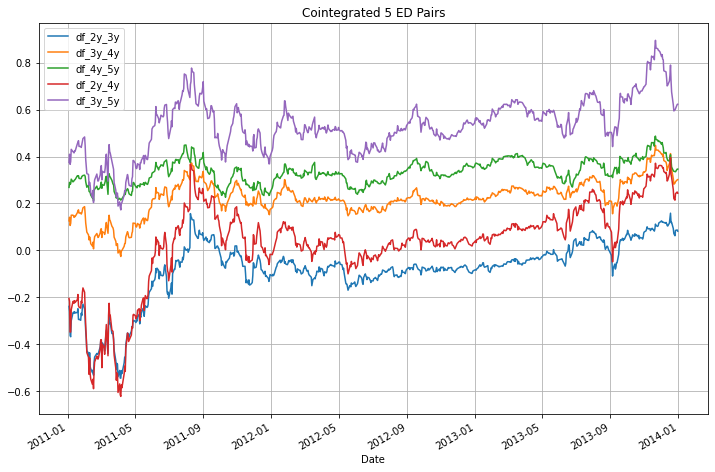

In [7]:
coin_pairs_df.plot(title="Cointegrated 5 ED Pairs", grid=True, figsize=(12, 8))

### Problem 2

#### Signal 1

In [8]:
### stationarity
for col in coin_pairs_df.columns:
    print(f"P-value of {col}: ", adfuller(coin_pairs_df[col], autolag='AIC')[1])

P-value of df_2y_3y:  0.39697093100047554
P-value of df_3y_4y:  0.10153207755219018
P-value of df_4y_5y:  0.013249201265601498
P-value of df_2y_4y:  0.12623320884555006
P-value of df_3y_5y:  0.05081415052899449


Obviously only cointegrated pair [4y, 5y] is stationary under 1% significance level, only [3y, 5y] is stationary under 5% significance level, only [3y, 4y] is stationary under 10% significance level.  
Other remaining pairs cannot be said stationary.

In [9]:
# fit signal 1 with AR(1) model
model_signal_1 = {}
for col in coin_pairs_df.columns:
    model_signal_1[f"model_{col}"] = AutoReg(coin_pairs_df[col].values, lags=1).fit()

### Problem 3

#### Signal 2

In [10]:
def ema(series, period=3, half_life=1):
    """
    Calculate EMA
    -------------
    Method 1. refer to https://www.investopedia.com/terms/e/ema.asp
    Method 2. self-defined ewma with given rolling window size and half life
        refer to https://ai.plainenglish.io/how-to-implement-ewma-plots-using-python-8a158e5bab48
    
    :param half_life:
    :param series: pd.Series; Price
    :param period: int; moving average period
    :return result: pd.Series; EMA
    """
    result = series.copy()
    if half_life:
        result = result.rolling(period, min_periods=1).apply(lambda x: get_exp_average(x, period, half_life))
    else:
        # weight for current price data
        multiplier = 2 / (period + 1)
        for i in range(len(result)):
            if i == 0:
                result.iloc[i] = result.iloc[i]
            else:
                result.iloc[i] = result.iloc[i] * multiplier + result.iloc[i - 1] * (1 - multiplier)
    return result


def get_exp_weight(window, half_life):
    """
    Calculate exponential weights given a window and half life
    :param window:
    :param half_life:
    :return:
    """
    exp_wt = np.asarray([0.5 ** (1 / half_life)] * window) ** np.arange(window)
    return exp_wt[::-1] / np.sum(exp_wt)


def get_exp_average(series, window, half_life):
    """
    Calculate exponential average upon rolling window and half life
    :param series:
    :param window:
    :param half_life:
    :return:
    """
    if len(series) < window:
        weight = get_exp_weight(len(series), half_life/window*len(series))
        result = weight * series
    else:
        weight = get_exp_weight(window, half_life)
        result = weight * series
    return np.sum(result)


def get_halflife(s):
    """
    Calculate halflife of a time series
    :param s: pd.Series; a given time series
    :return halflife: int; halflife of a given time series
    """
    s_lag = s.shift(1)
    s_lag.iloc[0] = s_lag.iloc[1]
 
    s_ret = s - s_lag
    s_ret.iloc[0] = s_ret.iloc[1]
 
    s_lag2 = sm.add_constant(s_lag)
 
    model = sm.OLS(s_ret,s_lag2)
    res = model.fit()
 
    halflife = round(-np.log(2) / list(res.params)[1], 4)
    return halflife

In [11]:
# class TimeSeriesSignal2:
#     def __init__(self, lamb):
#         self.lamb = lamb
        
#     def signal_2(self, series):
#         result = series - series.ewm(alpha=self.lamb).mean()
#         return result
    
#     def update_lambda(self, x):
#         self.lamb = x

        
# class Fitter:
#     def __init__(self, model, series, target_halflife=5):
#         self.model = model
#         self.series = series
#         self.target = target_halflife
    
#     def residuals(self, x):
#         m = self.model
#         m.update_lambda(x)
#         model_halflife = get_halflife(m.signal_2(self.series))
#         return model_halflife - self.target
    
#     def fit(self, x, solver='lm'):
#         return least_squares(self.residuals, x, method=solver)

#### Pick optimal $\lambda$ for each cointegrated time series

In [12]:
lamb_list = np.linspace(0.001, 0.999, 100)
optimal_lambda_dict = {}
for col in coin_pairs_df.columns:
    series = coin_pairs_df[col]
    cost_list = [(get_halflife(series - series.ewm(alpha=lamb).mean()) - 5) ** 2 for lamb in lamb_list]
    optimal_lambda_dict[col] = round(lamb_list[np.argmin(cost_list)], 4)

In [13]:
optimal_lambda_dict

{'df_2y_3y': 0.122,
 'df_3y_4y': 0.1522,
 'df_4y_5y': 0.122,
 'df_2y_4y': 0.1421,
 'df_3y_5y': 0.1522}

#### Construction of Signal 2 based their corresponding optimal $\lambda$

In [14]:
coin_pairs_ema_df = pd.DataFrame({
    key: coin_pairs_df[key] - coin_pairs_df[key].ewm(alpha=optimal_lambda_dict[key]).mean() 
    for key in optimal_lambda_dict.keys()
})
coin_pairs_ema_df.head(5)

,df_2y_3y,df_3y_4y,df_4y_5y,df_2y_4y,df_3y_5y
Date,,,,,
2011-01-03,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-04,-0.010004,0.007026,0.009965,-0.005760,0.015815
2011-01-05,-0.070280,-0.017140,0.000978,-0.084089,-0.016534
2011-01-06,-0.052702,-0.005587,0.003007,-0.057234,-0.003158
2011-01-07,0.011628,0.021357,0.016264,0.027290,0.035631


In [15]:
### stationarity
for col in coin_pairs_ema_df.columns:
    print("P-value: ", adfuller(coin_pairs_ema_df[col], autolag='AIC')[1])

P-value:  3.400857551064884e-11
P-value:  3.488003512535861e-12
P-value:  3.710055695081447e-09
P-value:  4.1808093443511885e-11
P-value:  1.662523253900289e-10


Since Signal 2 are time series cancelled EMA / trend and seasonality out, all time series are significantly stationary 

In [16]:
model_signal_2 = {}
for col in coin_pairs_ema_df.columns:
    model_signal_2[f"model_{col}"] = AutoReg(coin_pairs_ema_df[col].values, lags=1).fit()

#### Half life of signal 1 and signal 2

In [17]:
coin_pairs_df.apply(get_halflife)

df_2y_3y    70.0133
df_3y_4y    46.3832
df_4y_5y    24.7436
df_2y_4y    68.0815
df_3y_5y    38.3565
dtype: float64

For signal 1, since they are not stationary, half life for them could be much longer

In [18]:
coin_pairs_ema_df.apply(get_halflife)

df_2y_3y    5.1056
df_3y_4y    4.9749
df_4y_5y    5.1547
df_2y_4y    4.9315
df_3y_5y    5.0918
dtype: float64

For signal 2, since trend and seasonality are cancelled, with optimal $\lambda$, they are stationary and have a pre-determined half life apporximately equals to 5 days.

### Problem 4

#### Prediction using signal 1

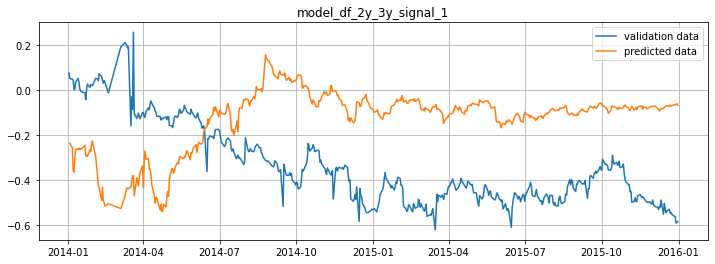

<Figure size 432x288 with 0 Axes>

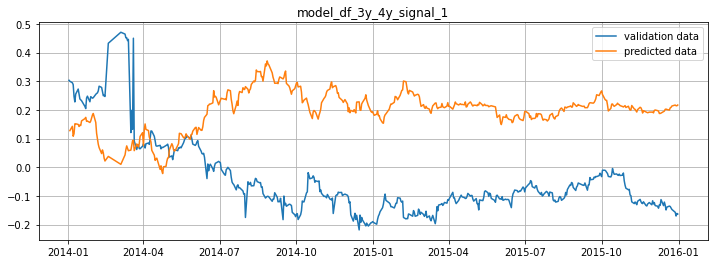

<Figure size 432x288 with 0 Axes>

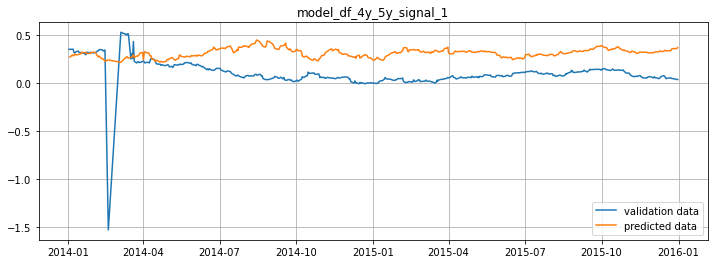

<Figure size 432x288 with 0 Axes>

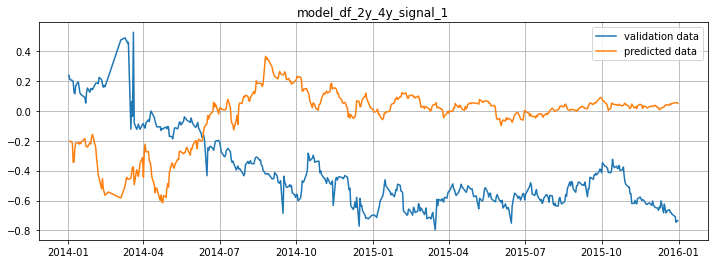

<Figure size 432x288 with 0 Axes>

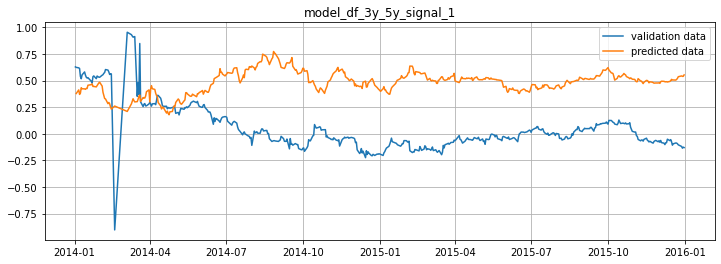

<Figure size 432x288 with 0 Axes>

In [40]:
for key in model_signal_1.keys():
    pred = model_signal_1[key].predict(start=0, end=len(validation_df) - 1, dynamic=False)
    plt.figure(figsize=(12, 4))
    plt.grid()
    plt.title(f"{key}_signal_1")
    plt.plot(validation_df.index, coin_pairs_validation_df[f"{key[6:]}"], label="validation data")
    plt.plot(validation_df.index, pred, label="predicted data")
    plt.legend(loc="best")
    plt.show()
    plt.clf()

Since signal 1 is not stationary, prediction using AR(1) model is not robust. As we can see from the plot above there is almost no prediction ability for this model, the trend is predicted as the opposite from the true value.

#### Prediction using signal 2  
Since signal 2 is stationary, the prediction is also stationary. For comparison, we should add cancelled trend and seasonality back.

accuracy score of signal 2 on validation data set model_df_2y_3y: 0.8913797817009619


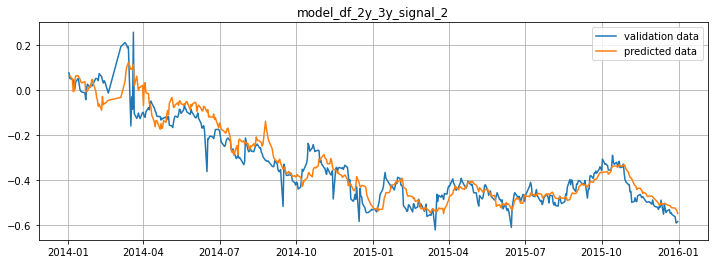

accuracy score of signal 2 on validation data set model_df_3y_4y: 0.8930958403625644


<Figure size 432x288 with 0 Axes>

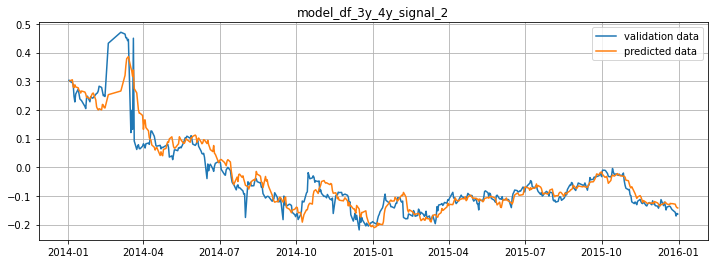

accuracy score of signal 2 on validation data set model_df_4y_5y: 0.5076507038997609


<Figure size 432x288 with 0 Axes>

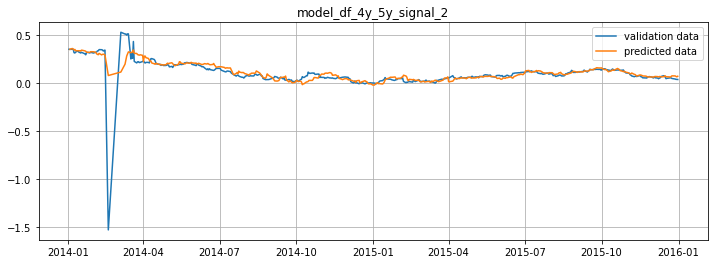

accuracy score of signal 2 on validation data set model_df_2y_4y: 0.8990586649372908


<Figure size 432x288 with 0 Axes>

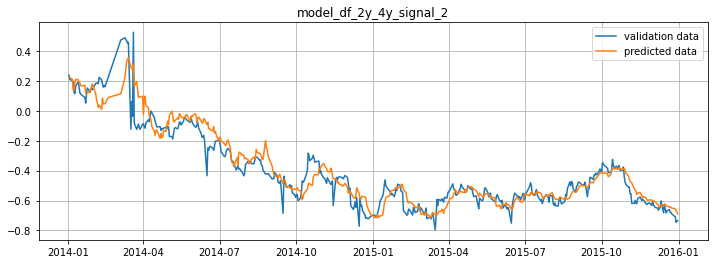

accuracy score of signal 2 on validation data set model_df_3y_5y: 0.822415517566829


<Figure size 432x288 with 0 Axes>

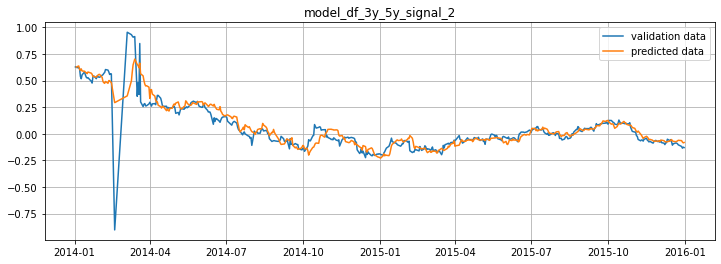

<Figure size 432x288 with 0 Axes>

In [39]:
for key in model_signal_2.keys():
    
    # calculate accuracy for prediction using R squared
    trend = coin_pairs_validation_df[key[6:]].ewm(alpha=optimal_lambda_dict[key[6:]]).mean()
    pred = model_signal_2[key].predict(start=0, end=len(validation_df) - 1, dynamic=False)
    true = coin_pairs_validation_df[f"{key[6:]}"]
    print(f"accuracy score of signal 2 on validation data set {key}: {r2_score(true.iloc[1:].values, pred[1:] + trend.iloc[1:].values)}")
    
    # plot true and predicted value
    plt.figure(figsize=(12, 4))
    plt.grid()
    plt.title(f"{key}_signal_2")
    plt.plot(validation_df.index, true, label="validation data")
    plt.plot(validation_df.index, pred + trend, label="predicted data")  # Add back trend and seasonality (ema)
    plt.legend(loc="best")
    plt.show()
    plt.clf()

### Problem 5

#### Predicting using signal 3  
$Signal 3 = (1 - \theta) Signal 1 + \theta Signal 2$  
1. Construct Signal 3 as a linear combination of signal 1 and signal 2, whereas their sum of weights equals to 1.
       
2. For hyperparameter ($\theta$) tuning, I am using mse as the metric. Since $\theta$ is from 0 to 1, it is chosen by picking $\theta$ with lowest mse on validation data.

In [33]:
theta_list = np.linspace(0.0001, 0.9999, 1000)
optimal_theta_dict = {}
for col in coin_pairs_df.columns:
    mse_list = []
    for theta in theta_list:
        signal3 = (1 - theta) * coin_pairs_df + theta * coin_pairs_ema_df
        model = AutoReg(signal3[col].values, lags=1).fit()
        pred = model.predict(start=0, end=len(validation_df) - 1, dynamic=False)
        mse_list.append(np.sum((coin_pairs_validation_df[col] - (pred + coin_pairs_validation_df[col].ewm(alpha=optimal_lambda_dict[col]).mean())) ** 2))
        optimal_theta_dict[col] = round(theta_list[np.argmin(mse_list)], 4)

In [34]:
optimal_theta_dict

{'df_2y_3y': 0.0541,
 'df_3y_4y': 0.0001,
 'df_4y_5y': 0.0001,
 'df_2y_4y': 0.0321,
 'df_3y_5y': 0.0001}

In [23]:
signal_3 = pd.DataFrame({col: coin_pairs_df[col] * (1 - theta) + coin_pairs_ema_df[col] * theta for col in coin_pairs_df.columns})
signal_3.head(5)

,df_2y_3y,df_3y_4y,df_4y_5y,df_2y_4y,df_3y_5y
Date,,,,,
2011-01-03,-0.000024,0.000013,0.000027,-0.000021,0.000038
2011-01-04,-0.010029,0.007040,0.009993,-0.005781,0.015854
2011-01-05,-0.070310,-0.017127,0.001006,-0.084115,-0.016496
2011-01-06,-0.052734,-0.005575,0.003035,-0.057263,-0.003120
2011-01-07,0.011597,0.021370,0.016293,0.027262,0.035671


In [35]:
signal_3.apply(get_halflife)

df_2y_3y    5.1056
df_3y_4y    4.9749
df_4y_5y    5.1547
df_2y_4y    4.9314
df_3y_5y    5.0918
dtype: float64

In [24]:
### stationarity
for col in signal_3.columns:
    print("P-value: ", adfuller(signal_3[col], autolag='AIC')[1])

P-value:  3.400226286874503e-11
P-value:  3.48782619340282e-12
P-value:  3.709797103418243e-09
P-value:  4.179703597012254e-11
P-value:  1.6627686039955899e-10


Though signal 3 has very little weight on signal 2 which is stationary and has half life of 5 days, signal 3 still inherited most of characteristics of signal 2. Since signal 3 is also significantly stationary and has half life approximately 5 days 

In [25]:
model_signal_3 = {}
for col in signal_3.columns:
    model_signal_3[f"model_{col}"] = AutoReg(signal_3[col].values, lags=1).fit()

accuracy score of signal 3 on validation data set model_df_2y_3y: 0.8913914847604717


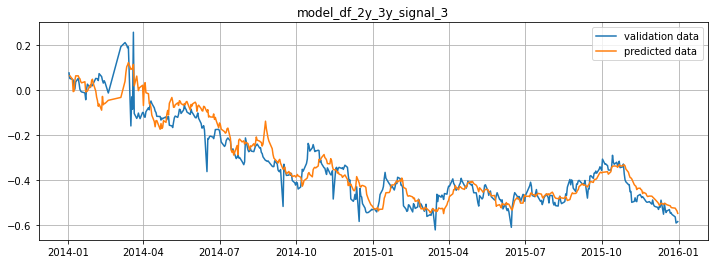

accuracy score of signal 3 on validation data set model_df_3y_4y: 0.8930827331623846


<Figure size 432x288 with 0 Axes>

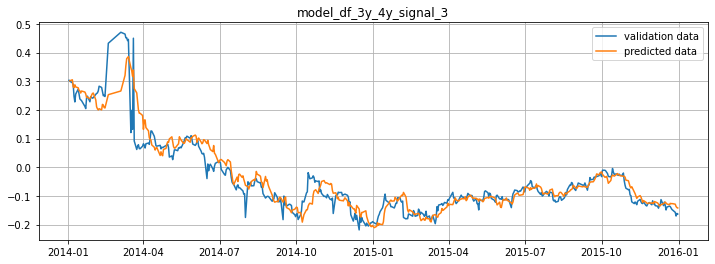

accuracy score of signal 3 on validation data set model_df_4y_5y: 0.5076274607337457


<Figure size 432x288 with 0 Axes>

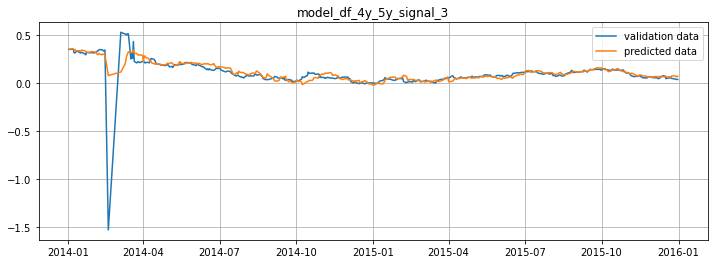

accuracy score of signal 3 on validation data set model_df_2y_4y: 0.8990621717980921


<Figure size 432x288 with 0 Axes>

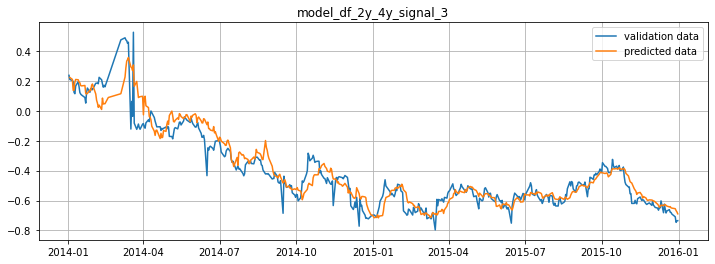

accuracy score of signal 3 on validation data set model_df_3y_5y: 0.8223956555949969


<Figure size 432x288 with 0 Axes>

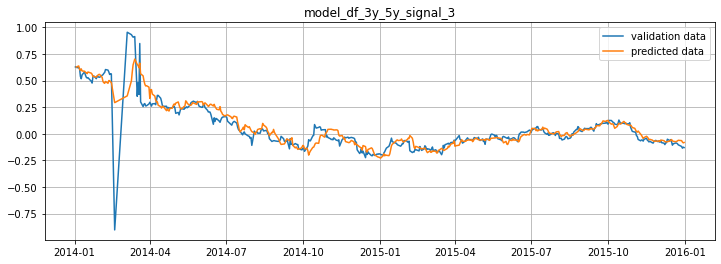

<Figure size 432x288 with 0 Axes>

In [38]:
for key in model_signal_3.keys():
    
    trend = coin_pairs_validation_df[key[6:]].ewm(alpha=optimal_lambda_dict[key[6:]]).mean()
    pred = model_signal_3[key].predict(start=0, end=len(validation_df) - 1, dynamic=False)
    true = coin_pairs_validation_df[f"{key[6:]}"]
    print(f"accuracy score of signal 3 on validation data set {key}: {r2_score(true.iloc[1:].values, pred[1:] + trend.iloc[1:].values)}")
    
    plt.figure(figsize=(12, 4))
    plt.grid()
    plt.title(f"{key}_signal_3")
    plt.plot(validation_df.index, true, label="validation data")
    plt.plot(validation_df.index, pred + trend, label="predicted data")
    plt.legend(loc="best")
    plt.show()
    plt.clf()

Signal 3 has similar prediction accuracy as signal 2 as we can see from R2

### Problem 6

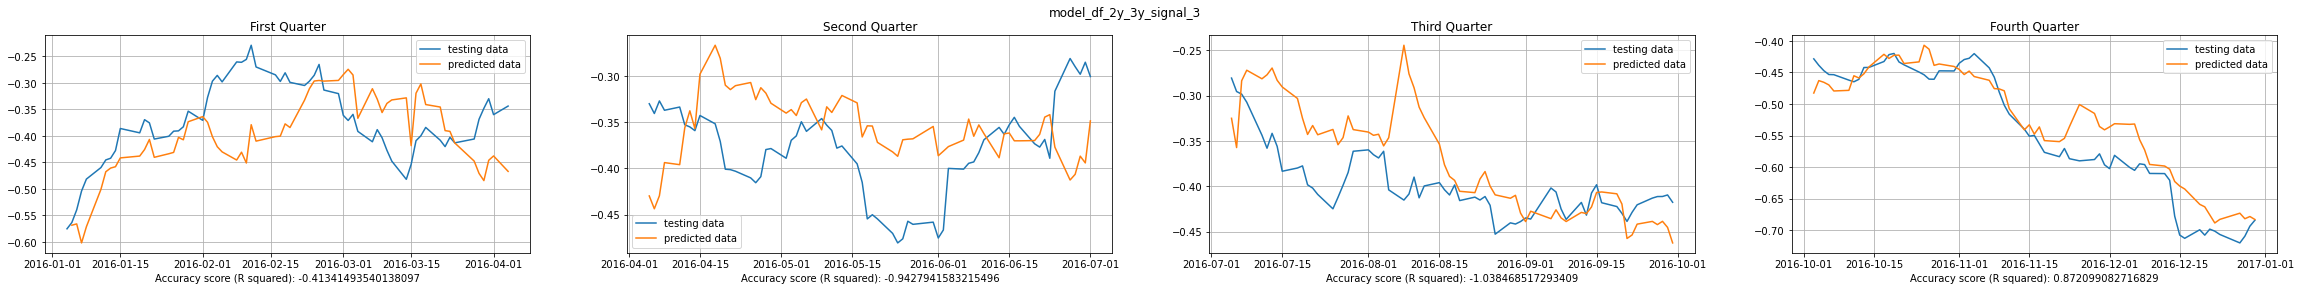

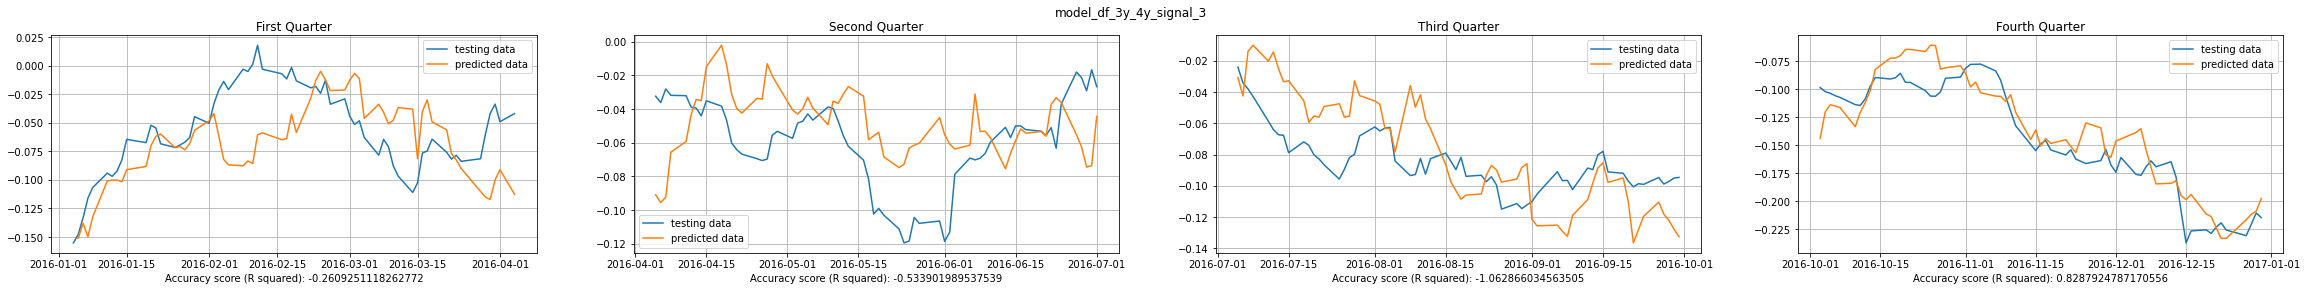

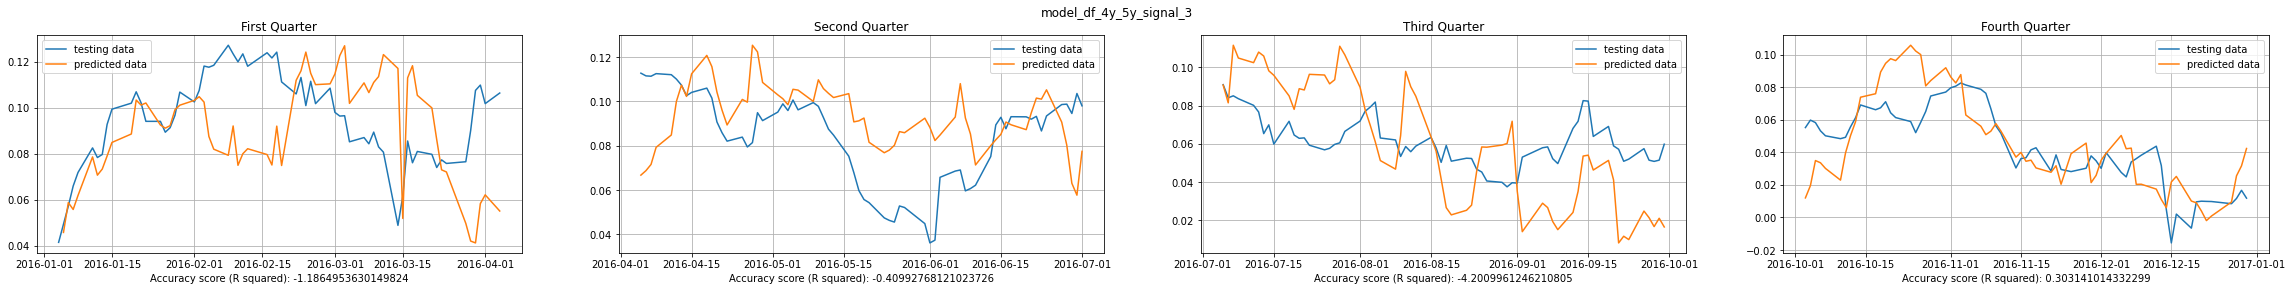

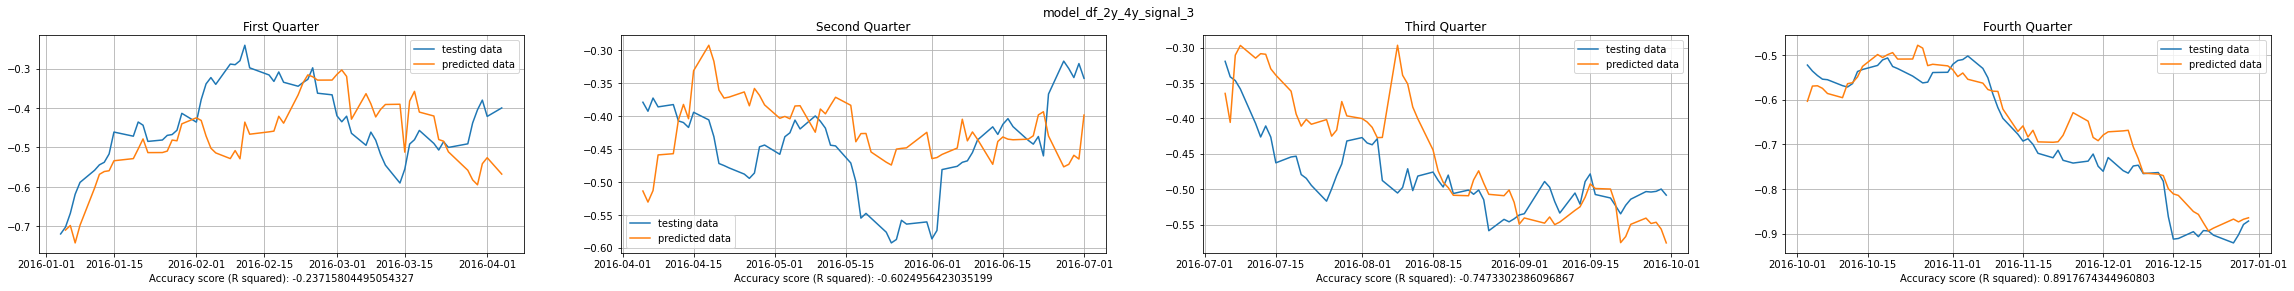

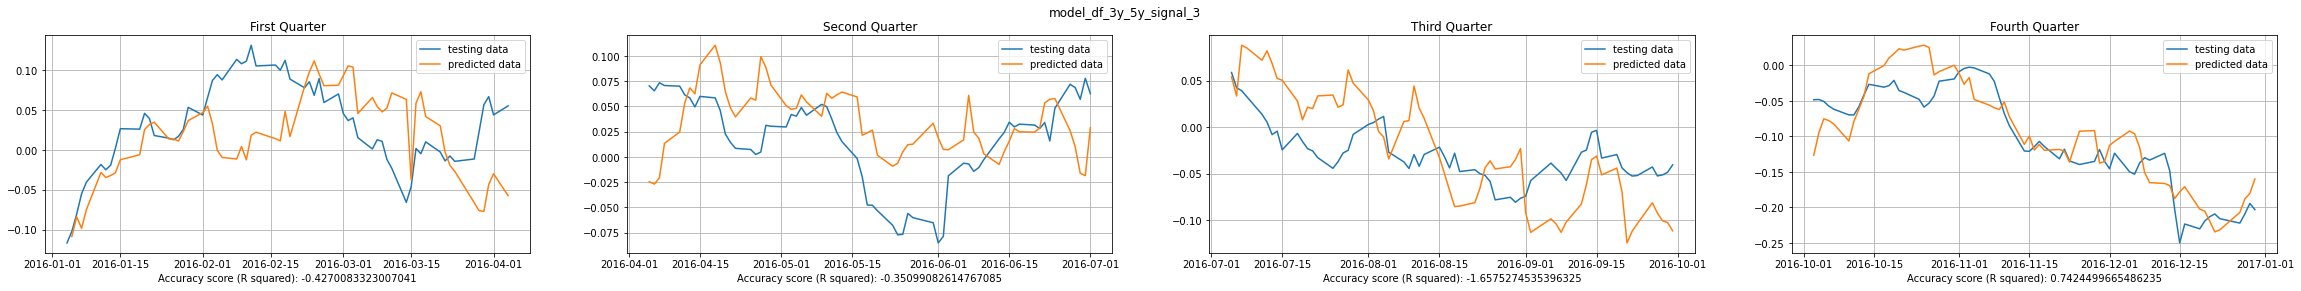

In [68]:
for key in model_signal_3.keys():
    
    trend = coin_pairs_testing_df[key[6:]].ewm(alpha=optimal_lambda_dict[key[6:]]).mean()
    pred = model_signal_3[key].predict(start=0, end=len(coin_pairs_testing_df) - 1, dynamic=False)
    true = coin_pairs_testing_df[f"{key[6:]}"]
    length = int(len(coin_pairs_testing_df) / 4)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 4))
    fig.suptitle(f"{key}_signal_3")

    ax1.plot(coin_pairs_testing_df.index[:length], true.iloc[:length], label="testing data")
    ax1.plot(coin_pairs_testing_df.index[:length], pred[:length] + trend.iloc[:length], label="predicted data")
    ax1.set_xlabel(f"Accuracy score (R squared): {r2_score(true.iloc[1:length], pred[1:length] + trend.iloc[1:length])}")
    ax1.set_title("First Quarter")
    ax1.legend(loc="best")
    ax1.grid()

    ax2.plot(coin_pairs_testing_df.index[length:length*2], true.iloc[length:length*2], label="testing data")
    ax2.plot(coin_pairs_testing_df.index[length:length*2], pred[length:length*2] + trend.iloc[length:length*2], label="predicted data")
    ax2.set_xlabel(f"Accuracy score (R squared): {r2_score(true.iloc[length:length*2], pred[length:length*2] + trend.iloc[length:length*2])}")
    ax2.set_title("Second Quarter")
    ax2.legend(loc="best")
    ax2.grid()
    
    ax3.plot(coin_pairs_testing_df.index[length*2:length*3], true.iloc[length*2:length*3], label="testing data")
    ax3.plot(coin_pairs_testing_df.index[length*2:length*3], pred[length*2:length*3] + trend.iloc[length*2:length*3], label="predicted data")
    ax3.set_xlabel(f"Accuracy score (R squared): {r2_score(true.iloc[length*2:length*3], pred[length*2:length*3] + trend.iloc[length*2:length*3])}")
    ax3.set_title("Third Quarter")
    ax3.legend(loc="best")
    ax3.grid()
    
    ax4.plot(coin_pairs_testing_df.index[length*3:], true.iloc[length*3:], label="testing data")
    ax4.plot(coin_pairs_testing_df.index[length*3:], pred[length*3:] + trend.iloc[length*3:], label="predicted data")
    ax4.set_xlabel(f"Accuracy score (R squared): {r2_score(true.iloc[length*3:], pred[length*3:] + trend.iloc[length*3:])}")
    ax4.set_title("Fourth Quarter")
    ax4.legend(loc="best")
    ax4.grid()